## About

Code to read .xml file export from Apple Health
Convert to individual csv files
Final .h5 export 

In [1]:
## Instructions
# 1. Set lb3_id
lb3_id = "LB3_011_phaseII"
# 2. set path_to_lb3_folder. This is where the LB3_XXx_phaseyy folder is located
path_to_lb3_folder = "/Users/jalpanchal/Documents/littlab/Data/"
path_to_lb3_folder = "/gdrive/public/DATA/Human_Data/LB3_PIONEER/"
# 3. Run all cells below

In [5]:

path_to_subject_folder = os.path.join(path_to_lb3_folder,lb3_id)
path_to_wearables = os.path.join(path_to_subject_folder,"wearables/")
path_to_preprocessed = os.path.join(path_to_wearables, "pre-processed/")
path_to_raw_activity = os.path.join(path_to_wearables,"raw/apple_health_export/")
path_to_activity_csvs = os.path.join(path_to_preprocessed,"activity/")

In [6]:
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from dateutil import parser
import os
from tqdm import tqdm
from parse import compile


import sys
sys.path.insert(1, './../tools/')
from apple_parse import *

In [7]:
# -*- coding: utf-8 -*-
"""
applehealthdata.py: Extract data from Apple Health App's export.xml.
Copyright (c) 2016 Nicholas J. Radcliffe
Licence: MIT
"""
import os
import re
import sys

from xml.etree import ElementTree
from collections import Counter, OrderedDict

__version__ = '1.3'

RECORD_FIELDS = OrderedDict((
    ('sourceName', 's'),
    ('sourceVersion', 's'),
    ('device', 's'),
    ('type', 's'),
    ('unit', 's'),
    ('creationDate', 'd'),
    ('startDate', 'd'),
    ('endDate', 'd'),
    ('value', 'n'),
))

ACTIVITY_SUMMARY_FIELDS = OrderedDict((
    ('dateComponents', 'd'),
    ('activeEnergyBurned', 'n'),
    ('activeEnergyBurnedGoal', 'n'),
    ('activeEnergyBurnedUnit', 's'),
    ('appleExerciseTime', 's'),
    ('appleExerciseTimeGoal', 's'),
    ('appleStandHours', 'n'),
    ('appleStandHoursGoal', 'n'),
))

WORKOUT_FIELDS = OrderedDict((
    ('sourceName', 's'),
    ('sourceVersion', 's'),
    ('device', 's'),
    ('creationDate', 'd'),
    ('startDate', 'd'),
    ('endDate', 'd'),
    ('workoutActivityType', 's'),
    ('duration', 'n'),
    ('durationUnit', 's'),
    ('totalDistance', 'n'),
    ('totalDistanceUnit', 's'),
    ('totalEnergyBurned', 'n'),
    ('totalEnergyBurnedUnit', 's'),
))

FIELDS = {
    'Record': RECORD_FIELDS,
    'ActivitySummary': ACTIVITY_SUMMARY_FIELDS,
    'Workout': WORKOUT_FIELDS,
}


PREFIX_RE = re.compile('^HK.*TypeIdentifier(.+)$')
ABBREVIATE = True
VERBOSE = True

def format_freqs(counter):
    """
    Format a counter object for display.
    """
    return '\n'.join('%s: %d' % (tag, counter[tag])
                     for tag in sorted(counter.keys()))


def format_value(value, datatype):
    """
    Format a value for a CSV file, escaping double quotes and backslashes.
    None maps to empty.
    datatype should be
        's' for string (escaped)
        'n' for number
        'd' for datetime
    """
    if value is None:
        return ''
    elif datatype == 's':  # string
        return '"%s"' % value.replace('\\', '\\\\').replace('"', '\\"')
    elif datatype in ('n', 'd'):  # number or date
        return value
    else:
        raise KeyError('Unexpected format value: %s' % datatype)


def abbreviate(s, enabled=ABBREVIATE):
    """
    Abbreviate particularly verbose strings based on a regular expression
    """
    m = re.match(PREFIX_RE, s)
    return m.group(1) if enabled and m else s


class HealthDataExtractor(object):
    """
    Extract health data from Apple Health App's XML export, export.xml.
    Inputs:
        path:      Relative or absolute path to export.xml
        verbose:   Set to False for less verbose output
    Outputs:
        Writes a CSV file for each record type found, in the same
        directory as the input export.xml. Reports each file written
        unless verbose has been set to False.
    """
    def __init__(self, path, verbose=VERBOSE):
        self.in_path = path
        self.verbose = verbose
        self.directory = os.path.abspath(os.path.split(path)[0])
        with open(path) as f:
            self.report('Reading data from %s . . . ' % path, end='')
            self.data = ElementTree.parse(f)
            self.report('done')
        self.root = self.data._root
        self.nodes = list(self.root)
        self.n_nodes = len(self.nodes)
        self.abbreviate_types()
        self.collect_stats()

    def report(self, msg, end='\n'):
        if self.verbose:
            print(msg, end=end)
            sys.stdout.flush()

    def count_tags_and_fields(self):
        self.tags = Counter()
        self.fields = Counter()
        for record in self.nodes:
            self.tags[record.tag] += 1
            for k in record.keys():
                self.fields[k] += 1

    def count_record_types(self):
        """
        Counts occurrences of each type of (conceptual) "record" in the data.
        In the case of nodes of type 'Record', this counts the number of
        occurrences of each 'type' or record in self.record_types.
        In the case of nodes of type 'ActivitySummary' and 'Workout',
        it just counts those in self.other_types.
        The slightly different handling reflects the fact that 'Record'
        nodes come in a variety of different subtypes that we want to write
        to different data files, whereas (for now) we are going to write
        all Workout entries to a single file, and all ActivitySummary
        entries to another single file.
        """
        self.record_types = Counter()
        self.other_types = Counter()
        for record in self.nodes:
            if record.tag == 'Record':
                self.record_types[record.attrib['type']] += 1
            elif record.tag in ('ActivitySummary', 'Workout'):
                self.other_types[record.tag] += 1
            elif record.tag in ('Export', 'Me'):
                pass
            else:
                self.report('Unexpected node of type %s.' % record.tag)

    def collect_stats(self):
        self.count_record_types()
        self.count_tags_and_fields()

    def open_for_writing(self):
        self.handles = {}
        self.paths = []
        for kind in (list(self.record_types) + list(self.other_types)):
            
            path = os.path.join(self.directory, '%s.csv' % abbreviate(kind))
            f = open(path, 'w')
            headerType = (kind if kind in ('Workout', 'ActivitySummary')
                               else 'Record')
            f.write(','.join(FIELDS[headerType].keys()) + '\n')
            self.handles[kind] = f
            self.report('Opening %s for writing' % path)
            
        print(self.directory)
        print(os.path.join(self.directory, "./../../pre-processed/activity"))

    def abbreviate_types(self):
        """
        Shorten types by removing common boilerplate text.
        """
        for node in self.nodes:
            if node.tag == 'Record':
                if 'type' in node.attrib:
                    node.attrib['type'] = abbreviate(node.attrib['type'])

    def write_records(self):
        kinds = FIELDS.keys()
        for node in self.nodes:
            if node.tag in kinds:
                attributes = node.attrib
                kind = attributes['type'] if node.tag == 'Record' else node.tag
                values = [format_value(attributes.get(field), datatype)
                          for (field, datatype) in FIELDS[node.tag].items()]
                line = ','.join(values) + '\n'
                self.handles[kind].write(line)

    def close_files(self):
        for (kind, f) in self.handles.items():
            f.close()
            self.report('Written %s data.' % abbreviate(kind))

    def extract(self):
        self.open_for_writing()
        self.write_records()
        self.close_files()

    def report_stats(self):
        print('\nTags:\n%s\n' % format_freqs(self.tags))
        print('Fields:\n%s\n' % format_freqs(self.fields))
        print('Record types:\n%s\n' % format_freqs(self.record_types))

In [8]:
# creates folder for saving pre-processed data
try : 
    os.mkdir(path_to_preprocessed)
    print("Folder created")
except:
    print("Folder exists")

try : 
    os.mkdir(path_to_activity_csvs)
    print("Folder created")
except:
    print("Folder exists")



Folder exists
Folder exists


### extract csvs from export.xml

In [9]:
data = HealthDataExtractor(os.path.join(path_to_raw_activity,"export.xml"))
# data.report_stats()
data.extract()

Reading data from /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/export.xml . . . done
Unexpected node of type ExportDate.
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/HeartRate.csv for writing
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/OxygenSaturation.csv for writing
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/RespiratoryRate.csv for writing
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/StepCount.csv for writing
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/DistanceWalkingRunning.csv for writing
Opening /gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_011_phaseII/wearables/raw/apple_health_export/BasalEnergyBurned.csv for writing
Opening /gdrive/public/DATA/Human_D

## Move CSVs to pre-processed

In [10]:
csv_files = [c for c in os.listdir(path_to_raw_activity) if c.endswith('.csv')]
for c in csv_files:
    os.rename(os.path.join(path_to_raw_activity,c), os.path.join(path_to_activity_csvs,c))

## Read HR, SDNN, Respiration rate

In [11]:
#parsing HR data
try : 
    hr_data = pd.read_csv(path_to_activity_csvs+"HeartRate.csv")
    hr_data['timeStamp'] = pd.to_datetime(hr_data['startDate'], utc=False)
    hr_data = hr_data.rename(columns={"value": "heartRate"})
    # hr_data['samplingInterval'] = pd.DataFrame(hr_data.timeStamp.diff())/np.timedelta64(1, 's')

    hr_data = hr_data[['timeStamp','heartRate' ]]
    hr_data = hr_data.set_index('timeStamp', drop=True)
except:
    print("no HR Data available")


In [12]:
# #parsing HRV - SDNN data
try : 
    sdnn_data = pd.read_csv(path_to_activity_csvs+"HeartRateVariabilitySDNN.csv")
    sdnn_data['timeStamp'] = pd.to_datetime(sdnn_data['startDate'], utc=False)
    sdnn_data = sdnn_data.rename(columns={"value": "sdnn"})
    # hr_data['samplingInterval'] = pd.DataFrame(hr_data.timeStamp.diff())/np.timedelta64(1, 's')

    sdnn_data = sdnn_data[['timeStamp','sdnn' ]]
    sdnn_data = sdnn_data.set_index('timeStamp', drop=True)
except:
    print("no HRV Data available")

In [13]:
#parsing Respiration data
resp_data = pd.read_csv(path_to_activity_csvs+"RespiratoryRate.csv")
resp_data['timeStamp'] = pd.to_datetime(resp_data['startDate'], utc=False)
resp_data = resp_data.rename(columns={"value": "respirationRate"})
# hr_data['samplingInterval'] = pd.DataFrame(hr_data.timeStamp.diff())/np.timedelta64(1, 's')

resp_data = resp_data[['timeStamp','respirationRate' ]]
resp_data = resp_data.set_index('timeStamp', drop=True)
# hr_data = hr_data.sort_values(by=['timeStamp'])

In [14]:
#combining the 3
try : 
    ans_data = pd.concat([hr_data, sdnn_data, resp_data])
except:
    ans_data = pd.concat([hr_data, resp_data])
ans_data =  ans_data.sort_values(by=['timeStamp'])

In [15]:
#correcting timestamop
ans_data.index = pd.to_datetime(ans_data.index).tz_convert('US/Eastern')
ans_data

,heartRate,sdnn,respirationRate
timeStamp,,,
2022-09-15 14:31:07-04:00,84.0000,NaN,NaN
2022-09-15 14:33:31-04:00,NaN,44.7955,NaN
2022-09-15 14:33:31-04:00,91.2948,NaN,NaN
2022-09-15 14:35:46-04:00,87.0000,NaN,NaN
2022-09-15 14:38:27-04:00,93.0000,NaN,NaN
...,...,...,...
2022-09-20 10:45:26-04:00,66.0000,NaN,NaN
2022-09-20 10:45:37-04:00,67.0000,NaN,NaN
2022-09-20 10:45:42-04:00,68.0000,NaN,NaN


## Fetch Meta data to trim

In [16]:
meta_data = pd.read_csv(os.path.join(path_to_wearables, "wearables_metadata.csv"))

In [17]:
meta_data

,property,value
0,lb3_id,LB3_011_phaseII
1,watch_hand,left
2,study_start,9/15/22 11:56
3,study_end,9/22/22 11:15


In [18]:
# trim data outside trial
#select data
str_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_start'].values[0]).tz_localize('US/Eastern')

end_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_end'].values[0]).tz_localize('US/Eastern')

ans_data = ans_data[(ans_data.index>=str_time) & (ans_data.index<=end_time)]



In [19]:
ans_data

,heartRate,sdnn,respirationRate
timeStamp,,,
2022-09-15 14:31:07-04:00,84.0000,NaN,NaN
2022-09-15 14:33:31-04:00,NaN,44.7955,NaN
2022-09-15 14:33:31-04:00,91.2948,NaN,NaN
2022-09-15 14:35:46-04:00,87.0000,NaN,NaN
2022-09-15 14:38:27-04:00,93.0000,NaN,NaN
...,...,...,...
2022-09-20 10:45:26-04:00,66.0000,NaN,NaN
2022-09-20 10:45:37-04:00,67.0000,NaN,NaN
2022-09-20 10:45:42-04:00,68.0000,NaN,NaN


## Saving heart data to hdf5

In [20]:
path_to_save_ansdata = os.path.join(path_to_preprocessed,"watch_heart.h5")

#write datafrae to h5
ans_data.to_hdf(path_to_save_ansdata, key="heart", mode ='w')

## Combining Acc data into one file

In [21]:
path_to_raw_acc_files = os.path.join(path_to_wearables,"raw/accelerometer/")

In [22]:
# to parse hotswap file
def parse_hotswap_file():
    hotswap_file = open(os.path.join(path_to_wearables, "hotswap.txt"), 'r').read()[:-1].split('\n\n')
    hotswap_parser = compile("/starthotswap\ntime: {time}\nTag: {tag}\n/endhotswap")

    hotswaps = []
    for entry in hotswap_file:
        parsed = hotswap_parser.parse(entry)
        if parsed is not None:
            hotswaps.append(parsed.named)

    hotswaps = pd.DataFrame(hotswaps)
    hotswaps['time'] =  pd.DatetimeIndex(pd.to_datetime(hotswaps['time'])).tz_localize("US/Eastern")

    hotswaps = hotswaps.groupby((hotswaps["tag"] != hotswaps["tag"].shift()).cumsum()).agg({"time" : ["min", "max"]})
    return hotswaps

hotswaps = parse_hotswap_file()
display(hotswaps)


time                          
                          min                       max
tag                                                    
1   2022-09-15 11:56:00-04:00 2022-09-16 11:24:00-04:00
2   2022-09-16 11:26:00-04:00 2022-09-18 13:32:00-04:00
3   2022-09-18 13:34:00-04:00 2022-09-19 11:24:00-04:00
4   2022-09-19 11:26:00-04:00 2022-09-20 11:18:00-04:00
5   2022-09-20 11:23:00-04:00 2022-09-22 11:15:00-04:00

In [23]:
#fetch each csv as a data frame
csv_files = [c for c in os.listdir(path_to_raw_acc_files) if c.endswith('.csv') and not c.startswith("._")]

#sort them based on date
csv_files = np.sort(csv_files)
files_num = len(csv_files)


acc_parser = compile("{start}-{end}_accRecorder.csv")

def parse_acc_files():
    all_files = []
    for file in csv_files:
        parsed = acc_parser.parse(file)
        st_time = datetime.strptime(parsed['start'], "%y%m%d_%H%M%S")
        end_time = datetime.strptime(parsed['end'], "%y%m%d_%H%M%S")
        all_files.append({
            'file': file,
            'start': st_time,
            'end': end_time
        })
    all_files = pd.DataFrame(all_files)
    all_files['start'] =  pd.DatetimeIndex(pd.to_datetime(all_files['start'])).tz_localize("US/Eastern")
    all_files['end'] =  pd.DatetimeIndex(pd.to_datetime(all_files['end'])).tz_localize("US/Eastern")

    return all_files
file_times = parse_acc_files()
display(file_times)

consecutive_file_list = []
consecutive_file_list.append(0)
end_time = file_times.at[0, 'end']
print(end_time)
print(file_times['start'])
while end_time in file_times['start']:
    new_idx = file_times[file_times['start'] == end_time].index[0]
    consecutive_file_list.append(new_idx)

    end_time = file_times.at[new_idx, 'end']
print(consecutive_file_list)

,file,start,end
0,220914_113713-220914_173713_accRecorder.csv,2022-09-14 11:37:13-04:00,2022-09-14 17:37:13-04:00
1,220914_173713-220914_233713_accRecorder.csv,2022-09-14 17:37:13-04:00,2022-09-14 23:37:13-04:00
2,220914_233713-220915_053713_accRecorder.csv,2022-09-14 23:37:13-04:00,2022-09-15 05:37:13-04:00
3,220915_053713-220915_113713_accRecorder.csv,2022-09-15 05:37:13-04:00,2022-09-15 11:37:13-04:00
4,220915_113713-220915_173713_accRecorder.csv,2022-09-15 11:37:13-04:00,2022-09-15 17:37:13-04:00
...,...,...,...
72,220921_054516-220921_114516_accRecorder.csv,2022-09-21 05:45:16-04:00,2022-09-21 11:45:16-04:00
73,220921_114516-220921_174516_accRecorder.csv,2022-09-21 11:45:16-04:00,2022-09-21 17:45:16-04:00
74,220921_174516-220921_234516_accRecorder.csv,2022-09-21 17:45:16-04:00,2022-09-21 23:45:16-04:00
75,220921_234516-220922_054516_accRecorder.csv,2022-09-21 23:45:16-04:00,2022-09-22 05:45:16-04:00


2022-09-14 17:37:13-04:00
0    2022-09-14 11:37:13-04:00
1    2022-09-14 17:37:13-04:00
2    2022-09-14 23:37:13-04:00
3    2022-09-15 05:37:13-04:00
4    2022-09-15 11:37:13-04:00
                ...           
72   2022-09-21 05:45:16-04:00
73   2022-09-21 11:45:16-04:00
74   2022-09-21 17:45:16-04:00
75   2022-09-21 23:45:16-04:00
76   2022-09-22 05:45:16-04:00
Name: start, Length: 77, dtype: datetime64[ns, US/Eastern]
[0]


In [103]:
def isOverlap(t1_start, t1_end, t2_start, t2_end):
    return max(t1_start, t2_start) < min(t1_end, t2_end)

def string_together_files(files):
    pass

for hotswap_idx in hotswaps.index:
    if hotswap_idx != 2:
        continue
    overlaps = np.zeros(len(file_times), dtype=bool)
    for ind, row in file_times.iterrows():
        overlaps[ind] = isOverlap(
            hotswaps['time'].loc[hotswap_idx]['min'],
            hotswaps['time'].loc[hotswap_idx]['max'],
            row['start'],
            row['end']
            )

    overlapped_files = file_times[overlaps]
    # display(overlapped_files)

    for file in overlapped_files['file']:
        df = pd.read_csv(os.path.join(path_to_raw_acc_files, file))

        max_var = max(
            df['accelerometerAccelerationX(G)'].var(),
            df['accelerometerAccelerationY(G)'].var(),
            df['accelerometerAccelerationZ(G)'].var()
        )
        # if max_var < 1e-6:
        #     continue
        
        # break
    break

display(overlapped_files)
display(hotswaps.loc[hotswap_idx])

,file,start,end
7,220916_053713-220916_112958_accRecorder.csv,2022-09-16 05:37:13-04:00,2022-09-16 11:29:58-04:00
8,220916_053713-220916_113713_accRecorder.csv,2022-09-16 05:37:13-04:00,2022-09-16 11:37:13-04:00
9,220916_113713-220916_120409_accRecorder.csv,2022-09-16 11:37:13-04:00,2022-09-16 12:04:09-04:00
10,220916_114304-220916_174304_accRecorder.csv,2022-09-16 11:43:04-04:00,2022-09-16 17:43:04-04:00
11,220916_174304-220916_234304_accRecorder.csv,2022-09-16 17:43:04-04:00,2022-09-16 23:43:04-04:00
12,220916_234304-220917_054304_accRecorder.csv,2022-09-16 23:43:04-04:00,2022-09-17 05:43:04-04:00
13,220917_054304-220917_114304_accRecorder.csv,2022-09-17 05:43:04-04:00,2022-09-17 11:43:04-04:00
14,220917_105709-220917_165709_accRecorder.csv,2022-09-17 10:57:09-04:00,2022-09-17 16:57:09-04:00
15,220917_114304-220917_174304_accRecorder.csv,2022-09-17 11:43:04-04:00,2022-09-17 17:43:04-04:00
16,220917_165709-220917_225709_accRecorder.csv,2022-09-17 16:57:09-04:00,2022-09-17 22:57:09-04:00


time  min   2022-09-16 11:26:00-04:00
      max   2022-09-18 13:32:00-04:00
Name: 2, dtype: datetime64[ns, US/Eastern]

In [102]:
# display(overlapped_files)
# find files that string together i.e. a "path" of files
all_paths = []
for new_idx in range(1, len(overlapped_files)):
    if any(new_idx in i for i in all_paths):
        continue
    all_idx = [new_idx]

    end_time = overlapped_files.iloc[new_idx]['end'].to_datetime64()
    start_times = overlapped_files['start'].values

    while end_time in start_times:
        new_idx = list(overlapped_files['start'].values).index(end_time)
        end_time = overlapped_files.iloc[new_idx]['end'].to_datetime64()

        all_idx.append(new_idx)

    all_paths.append(all_idx)

# print(all_paths)
for path in all_paths:
    acc_data_all = pd.DataFrame()
    for idx in path:
        df = pd.read_csv(path_to_raw_acc_files+overlapped_files.iloc[idx]['file'])

        if len(df.index):
            time_col = 'loggingTime(txt)'
            try : 
                df["timeStamp"] = pd.to_datetime(df[time_col].values).tz_convert('US/Eastern')
            except:
                #done to slve issues when there is a day light saving change in the column. default function throws an error
                df["timeStamp"] = df[time_col].apply(lambda x:date_conv_helper(x))
            acc_data_all = pd.concat((acc_data_all, df))
    acc_data = acc_data_all.reset_index(drop=True)
    acc_data = acc_data.set_index('timeStamp')
    acc_data = acc_data.drop(columns=['loggingTime(txt)',"CMSensorRecorderAccelerometerTimestamp_sinceReboot(s)"])
    acc_data = acc_data.rename(columns={"accelerometerAccelerationX(G)": "accX", "accelerometerAccelerationY(G)" : "accY", "accelerometerAccelerationZ(G)" : "accZ"})

    acc_data = acc_data[(acc_data.index>=hotswaps['time'].loc[hotswap_idx]['min']) & (acc_data.index<=hotswaps['time'].loc[hotswap_idx]['max'])]
    max_var = max(
        acc_data['accX'].var(),
        acc_data['accY'].var(),
        acc_data['accZ'].var()
    )
    # print(max_var)
    print(acc_data.index.min(), acc_data.index.max())
    # break
    # print() 
print(hotswaps.loc[hotswap_idx])

,file,start,end
7,220916_053713-220916_112958_accRecorder.csv,2022-09-16 05:37:13-04:00,2022-09-16 11:29:58-04:00
8,220916_053713-220916_113713_accRecorder.csv,2022-09-16 05:37:13-04:00,2022-09-16 11:37:13-04:00
9,220916_113713-220916_120409_accRecorder.csv,2022-09-16 11:37:13-04:00,2022-09-16 12:04:09-04:00
10,220916_114304-220916_174304_accRecorder.csv,2022-09-16 11:43:04-04:00,2022-09-16 17:43:04-04:00
11,220916_174304-220916_234304_accRecorder.csv,2022-09-16 17:43:04-04:00,2022-09-16 23:43:04-04:00
12,220916_234304-220917_054304_accRecorder.csv,2022-09-16 23:43:04-04:00,2022-09-17 05:43:04-04:00
13,220917_054304-220917_114304_accRecorder.csv,2022-09-17 05:43:04-04:00,2022-09-17 11:43:04-04:00
14,220917_105709-220917_165709_accRecorder.csv,2022-09-17 10:57:09-04:00,2022-09-17 16:57:09-04:00
15,220917_114304-220917_174304_accRecorder.csv,2022-09-17 11:43:04-04:00,2022-09-17 17:43:04-04:00
16,220917_165709-220917_225709_accRecorder.csv,2022-09-17 16:57:09-04:00,2022-09-17 22:57:09-04:00


2022-09-16 11:26:00.005000-04:00 2022-09-16 12:04:07.040000-04:00
2022-09-16 11:43:02.940000-04:00 2022-09-17 12:15:16.207000-04:00
2022-09-17 10:57:07.286000-04:00 2022-09-17 11:29:12.206000-04:00
2022-09-17 12:15:16.145000-04:00 2022-09-17 12:15:16.207000-04:00
2022-09-17 11:29:12.186000-04:00 2022-09-17 11:29:12.206000-04:00
2022-09-17 11:29:12.186000-04:00 2022-09-17 11:29:12.206000-04:00
time  min   2022-09-16 11:26:00-04:00
      max   2022-09-18 13:32:00-04:00
Name: 2, dtype: datetime64[ns, US/Eastern]


In [99]:
display(acc_data)
print(hotswaps.loc[hotswap_idx])

,accX,accY,accZ
timeStamp,,,
2022-09-16 11:26:00.005000-04:00,0.002930,-0.004395,0.999268
2022-09-16 11:26:00.025000-04:00,0.002441,-0.007080,1.000977
2022-09-16 11:26:00.045000-04:00,0.003174,-0.006592,0.997803
2022-09-16 11:26:00.065000-04:00,0.004883,-0.005127,0.999023
2022-09-16 11:26:00.085000-04:00,0.004883,-0.005859,0.999023
...,...,...,...
2022-09-16 12:04:06.960000-04:00,0.050537,-0.136963,-0.987061
2022-09-16 12:04:06.980000-04:00,0.059814,-0.123535,-0.968506
2022-09-16 12:04:07-04:00,0.061035,-0.114014,-0.894043


time  min   2022-09-16 11:26:00-04:00
      max   2022-09-18 13:32:00-04:00
Name: 2, dtype: datetime64[ns, US/Eastern]


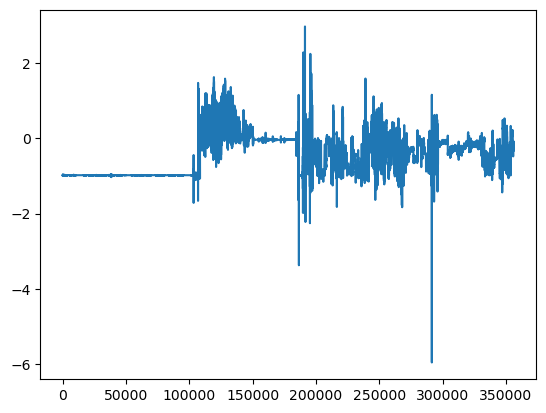

In [64]:
df = pd.read_csv(
    '/gdrive/public/DATA/Human_Data/LB3_PIONEER/LB3_005_phaseII/wearables/raw/accelerometer/211209_112436-211209_172436_accRecorder.csv'
)

plt.plot(df['accelerometerAccelerationZ(G)'])


In [65]:
plt.plot(
    pd.to_timedelta(df["loggingTime(txt)"]),
    df['accelerometerAccelerationX(G)']
)

ValueError: only leading negative signs are allowed

In [67]:
acc_data_all = pd.DataFrame()

def date_conv_helper(x):
    return pd.to_datetime(x).tz_convert('US/Eastern')
    
for n,file in enumerate(tqdm(csv_files)):    
    df = pd.read_csv(path_to_raw_acc_files+file)

    max_var = max(
        df['accelerometerAccelerationX(G)'].var(),
        df['accelerometerAccelerationY(G)'].var(),
        df['accelerometerAccelerationZ(G)'].var()
    )
    if max_var < 1e-6:
        continue

    #skipping empty files
    #renaming timestamp column
    if len(df.index):
        time_col = 'loggingTime(txt)'
        try : 
            df["timeStamp"] = pd.to_datetime(df[time_col].values).tz_convert('US/Eastern')
        except:
            #done to slve issues when there is a day light saving change in the column. default function throws an error
            df["timeStamp"] = df[time_col].apply(lambda x:date_conv_helper(x))
        acc_data_all = pd.concat((acc_data_all, df))
    else:
        continue 

100%|██████████| 77/77 [02:49<00:00,  2.20s/it]


In [68]:
acc_data_all

,loggingTime(txt),CMSensorRecorderAccelerometerTimestamp_sinceReboot(s),accelerometerAccelerationX(G),accelerometerAccelerationY(G),accelerometerAccelerationZ(G),timeStamp
0,2022-09-14T11:37:13.504-04:00,1921.143748,0.019287,-0.646729,-0.543945,2022-09-14 11:37:13.504000-04:00
1,2022-09-14T11:37:13.525-04:00,1921.163802,0.221924,-0.610840,-0.807373,2022-09-14 11:37:13.525000-04:00
2,2022-09-14T11:37:13.545-04:00,1921.183855,0.462646,-0.494873,-0.875977,2022-09-14 11:37:13.545000-04:00
3,2022-09-14T11:37:13.565-04:00,1921.203908,0.419678,-0.520264,-0.689941,2022-09-14 11:37:13.565000-04:00
4,2022-09-14T11:37:13.585-04:00,1921.223961,0.370361,-0.490479,-0.763672,2022-09-14 11:37:13.585000-04:00
...,...,...,...,...,...,...
3650,2022-09-22T11:35:17.828-04:00,693005.274958,0.228516,-0.293457,-0.913818,2022-09-22 11:35:17.828000-04:00
3651,2022-09-22T11:35:17.848-04:00,693005.295013,0.239502,-0.268799,-0.927979,2022-09-22 11:35:17.848000-04:00
3652,2022-09-22T11:35:17.868-04:00,693005.315069,0.226318,-0.276855,-0.947998,2022-09-22 11:35:17.868000-04:00
3653,2022-09-22T11:35:17.888-04:00,693005.335125,0.196045,-0.275146,-0.956787,2022-09-22 11:35:17.888000-04:00


In [69]:
acc_data = acc_data_all.reset_index(drop=True)
acc_data = acc_data.set_index('timeStamp')
acc_data = acc_data.drop(columns=['loggingTime(txt)',"CMSensorRecorderAccelerometerTimestamp_sinceReboot(s)"])
acc_data = acc_data.rename(columns={"accelerometerAccelerationX(G)": "accX", "accelerometerAccelerationY(G)" : "accY", "accelerometerAccelerationZ(G)" : "accZ"})


In [70]:
# trim data outside trial
#select data
str_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_start'].values[0]).tz_localize('US/Eastern')

end_time = pd.to_datetime(meta_data['value'][meta_data['property']=='study_end'].values[0]).tz_localize('US/Eastern')

acc_data = acc_data[(acc_data.index>=str_time) & (acc_data.index<=end_time)]

In [71]:
#Removing duplicates
acc_data_nodub = acc_data.drop_duplicates()
# acc_data_nodub = acc_data_nodub.reset_index(drop=True)

## Saving Acc Data to hdf5

In [72]:
path_to_save_accdata = os.path.join(path_to_preprocessed,"watch_acc.h5")

#write datafrae to h5
acc_data_nodub.to_hdf(path_to_save_accdata, key="acc", mode ='w')

## Test Plot by reading HDF5 Files

In [78]:

acc_h5_test = fetch_acc_data_h5(lb3_id, path_to_lb3_folder)
hr_h5_data = fetch_watch_hr_data_h5(lb3_id, path_to_lb3_folder)
subject_name  = {1: lb3_id}

#Process data
win_size = '2min'
hr_data_avg ={}
hr_data_std ={}
acc_data_avg = {}
acc_data_std= {}


for s in subject_name:
    hr_data_avg = hr_h5_data.resample(win_size).mean()
    hr_data_std = hr_h5_data.resample(win_size).std()
    
    acc_data_avg = acc_h5_test.resample(win_size).mean()
    acc_data_std = acc_h5_test.resample(win_size).std()

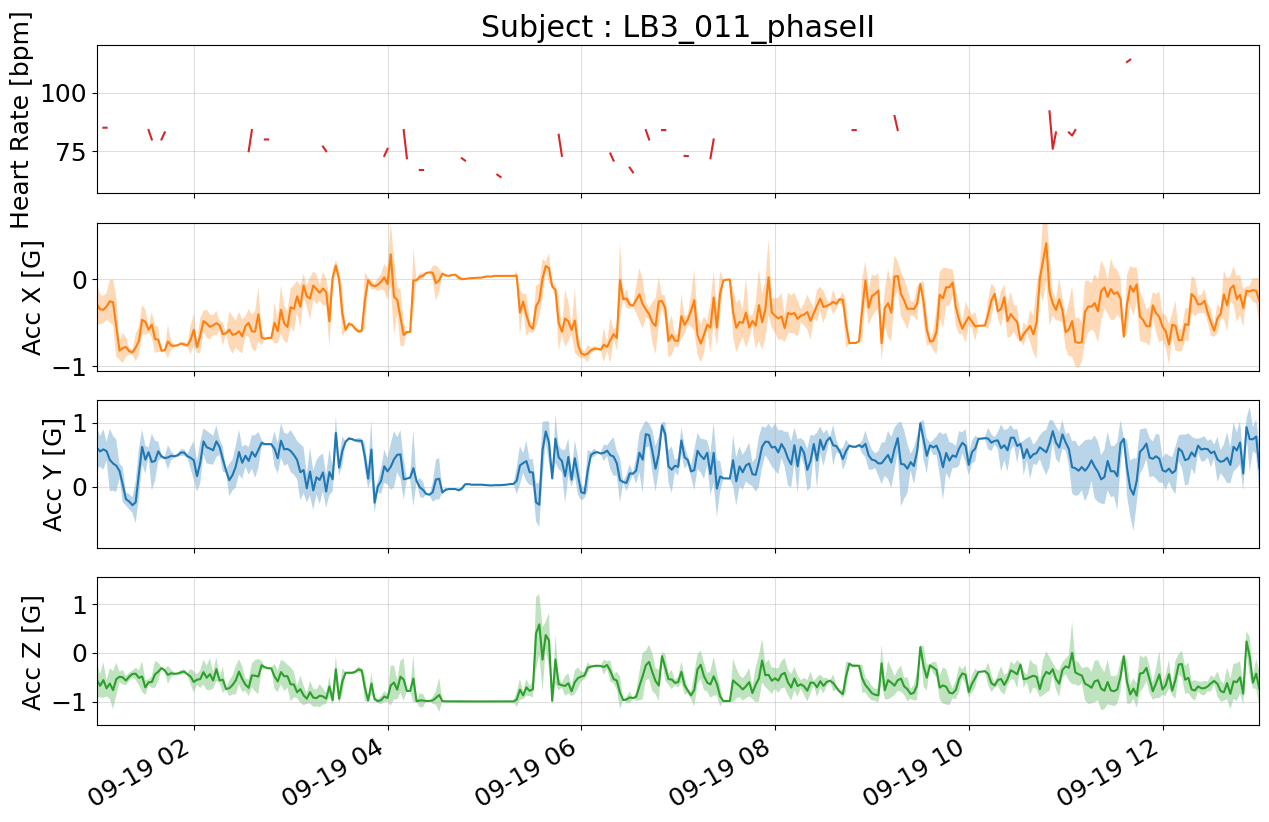

In [79]:
#plot all data
str_time = hr_h5_data.index[0]
end_time = hr_h5_data.index[-1]

#select data
str_time = parser.parse("Sep 19 2022 1:00")
str_time = pd.to_datetime(str_time).tz_localize('US/Eastern')

end_time = parser.parse("Sep 19 2022 13:00")
end_time = pd.to_datetime(end_time).tz_localize('US/Eastern')


plot_hr_acc(hr_data_avg, hr_data_std, acc_data_avg, acc_data_std, subject_name[1], str_time, end_time)